In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import re
import nltk
import pickle
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nltk.download('stopwords')

from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from tabulate import tabulate
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support, make_scorer, precision_score, recall_score, f1_score, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/books_1.Best_Books_Ever.csv')

# # If you want to see the columns
# df.head(10)
# df.info()

In [5]:
# Deleting NaN values
df = df.loc[~df['bookId'].isna()].copy()      # Without copy getting warning
df = df.loc[~df['description'].isna()].copy()

# Split the ratingsByStars column into five separate columns
df['ratingsByStars'] = df['ratingsByStars'].str.strip("[]")
df['ratingsByStars'] = df['ratingsByStars'].str.replace("'", "")
df[['ratingStar5', 'ratingStar4', 'ratingStar3', 'ratingStar2', 'ratingStar1']] = df['ratingsByStars'].str.split(',', expand = True)

# Assign to genreSingle the first genre of genres column
df['genres'] = df['genres'].str.strip("[]")
df['genres'] = df['genres'].str.replace("'", "")
df['genreSingle'] = df['genres'].str.split(',', expand = True)[0]

# Convert publishDate to datetime to extract year and create new column
def check_datetime(date): 
  try:
    return pd.to_datetime(date, infer_datetime_format = True) # Some dates have "May 20th 2010" format, others "05/20/2010", others nothing, etc 
  except ValueError:
    return pd.NaT

df['publishDate'] = df['publishDate'].apply(check_datetime)   # Some dates have different format. We need to extract year from any format
df = df.loc[~df['publishDate'].isna()].copy()                 # Some values are NaN so remove them
df['publishYear'] = df['publishDate'].dt.year.astype(int)     # And make all the dates as ints   

# # If you want to see the columns
# df.head(10)
# df.info()

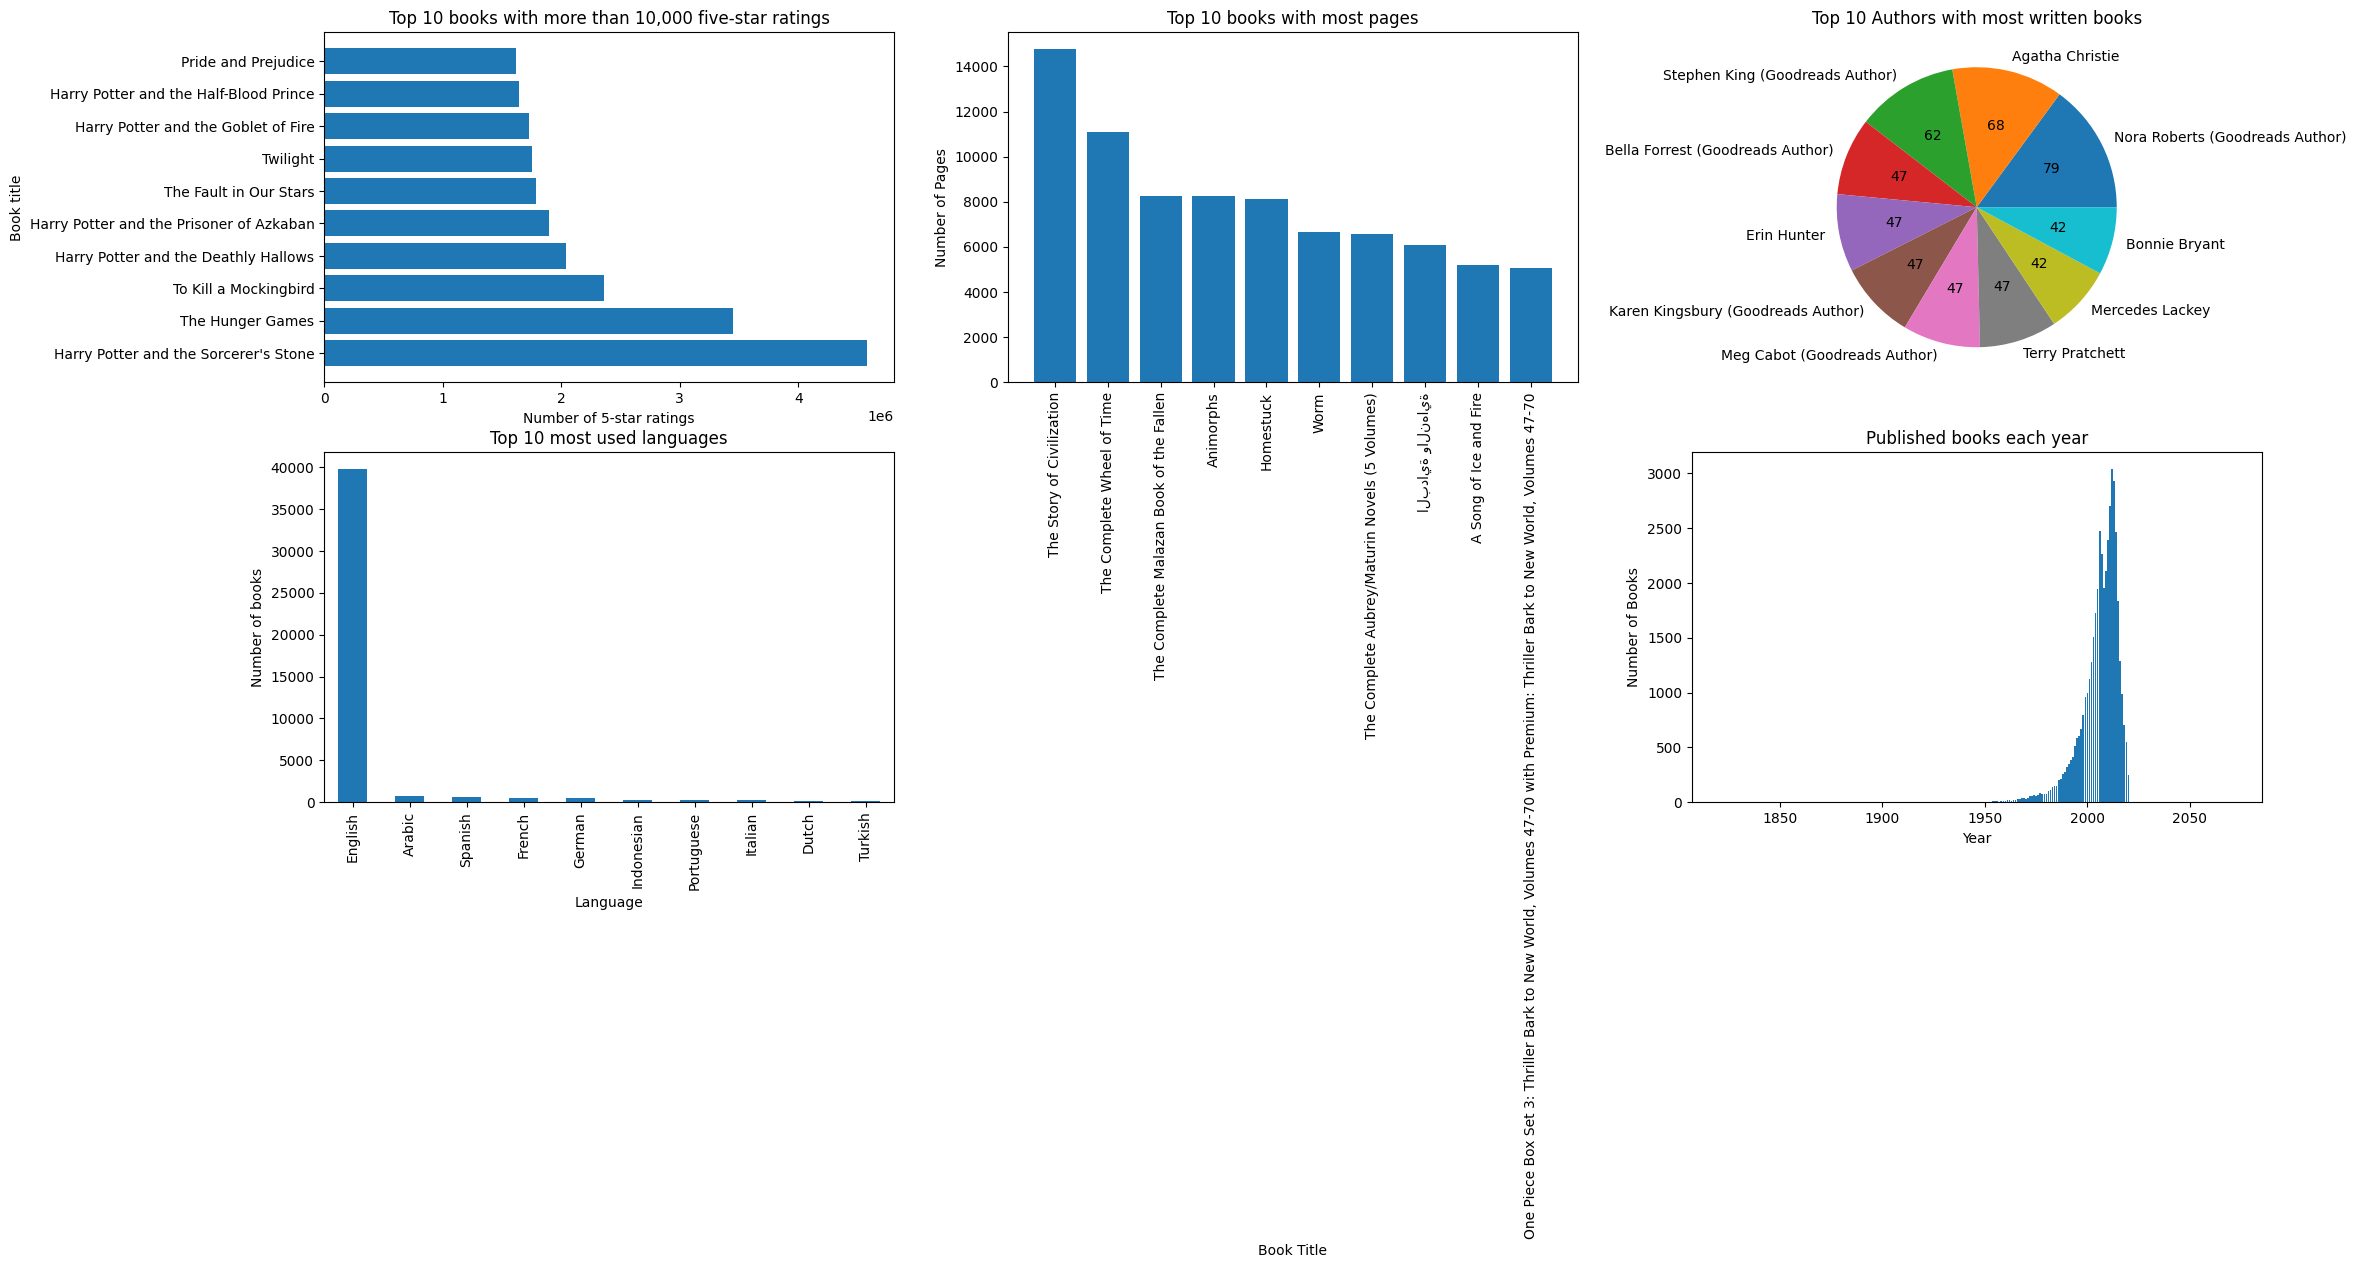

In [6]:
# Setting size of the graphs
plt.rcParams["figure.figsize"] = (25, 10)

# Deleting NaN values
df['pages'] = pd.to_numeric(df['pages'], errors = 'coerce')
df['ratingStar5'] = pd.to_numeric(df['ratingStar5'], errors = 'coerce')

df = df.loc[~df['pages'].isna()]
df = df.loc[~df['title'].isna()]
df = df.loc[~df['author'].isna()]
df = df.loc[~df['language'].isna()]
df = df.loc[~df['ratingStar5'].isna()]

# What are the 10 books with the most pages
topPagesBooks = df.sort_values('pages', ascending = False).head(10) # Just sort and take the first 10

plt.subplot(2, 3, 2)
plt.bar(topPagesBooks['title'], topPagesBooks['pages'])
plt.xticks(rotation = 90)
plt.title('Top 10 books with most pages')
plt.xlabel('Book Title')
plt.ylabel('Number of Pages')

# What are the 10 books with the most ratings
top_books = df[df['ratingStar5'] > 10000].nlargest(10, 'ratingStar5')

plt.subplot(2, 3, 1)
plt.barh(top_books['title'], top_books['ratingStar5'])
plt.xlabel('Number of 5-star ratings')
plt.ylabel('Book title')
plt.title('Top 10 books with more than 10,000 five-star ratings')

# Who are the 10 authors with the most written books
topAuthorsBooksWritten = df.groupby('author').size().sort_values(ascending = False)[:10]

plt.subplot(2, 3, 3)
plt.pie(topAuthorsBooksWritten, labels = topAuthorsBooksWritten.index, autopct = lambda pct: int(pct/100 * topAuthorsBooksWritten.sum()))
plt.title('Top 10 Authors with most written books')

# What are the most common languages written in your data books. For example the top 10
commonLanguage = df.groupby('language').size().sort_values(ascending = False).head(10)

plt.subplot(2, 3, 4)
commonLanguage.plot.bar()
plt.title('Top 10 most used languages')
plt.xlabel('Language')
plt.ylabel('Number of books')

# How many books are published each year
year_counts = df['publishYear'].value_counts()

plt.subplot(2, 3, 6)
plt.bar(year_counts.index, year_counts.values)
plt.title('Published books each year')
plt.xlabel('Year')
plt.ylabel('Number of Books')

# Plotting all the above 
plt.show()

In [7]:
# Filter to include only English books
df = df[df['language'] == 'English']

# 20k descriptions is the max. After that we out of ram 
descriptions = df['description'].values[:20000] 

# Similar books. Need 2 repeats one for unigram and one for bigram
for i in range(2):
  if i == 0:
    ngram_range = (1, 1)  # Unigram
  else:
    ngram_range = (2, 2)  # Bigram

  # Create the ngram TF-IDF
  tfidf_vectorizer = TfidfVectorizer(max_df = 1.0, min_df = 1, max_features = 1000, stop_words = 'english', ngram_range = ngram_range)
  tfidf = tfidf_vectorizer.fit_transform(descriptions)

  # Calculate the cosine similarity between each pair of books
  cosineSimilarity = cosine_similarity(tfidf)
  similarBooksIndices = np.argsort(cosineSimilarity)[:, -(100 + 1):]          # Getting indices of cosine using argsort. 100 + 1 for the book itself     
  similarBooksIndices = similarBooksIndices[:, :-1]                           # Removing the last column because it is the book itself 
  similarBooksIndices = np.array([row[::-1] for row in similarBooksIndices])  # Reverse the book indices so the most similar be first
  df = df.reset_index(drop = True)

  similarBooks = {}
  for i, row in enumerate(similarBooksIndices):
    bookId = df['bookId'][i]
    similarBooks[bookId] = [df['bookId'][similar] for similar in row] # Putting in our dictionary the books that are similar to bookId book

  def recommend(bookId, n):
    bookTitle = df[df['bookId'] == bookId]['title'].values[0] # Take the first the you will match
    numberOfBook = df[df['bookId'] == bookId].index[0]        # Take the index of the first book the you will match to use it for the score

    print(f"Recommending {n} books similar to: {bookTitle}")
    print('-' * 100)

    similarBooksIds = similarBooks.get(bookId, [])[:n]        # Get all books until n

    for i, similar_book_id in enumerate(similarBooksIds, 1):  # 1 to start the recommended from 1 and not from 0
      nameOfSimilar = df[df['bookId'] == similar_book_id]['title'].values[0]  # Take the first the you will match
      descriptionOfSimilar = df[df['bookId'] == similar_book_id]['description'].values[0] # Take the first the you will match

      numberOfSimilar = df.loc[df['title'] == nameOfSimilar].index[0]   # Take the index of the first book the you will match to use it for the score
      scoreOfSimilar = cosineSimilarity[numberOfBook, numberOfSimilar]  # To find the exact score need the cosine array

      print(f"Recommended {i}: {nameOfSimilar}")
      print(f"Description: {descriptionOfSimilar}")
      print(f"(score: {scoreOfSimilar})\n")

  recommend('2767052-the-hunger-games', 5) # Example

Recommending 5 books similar to: The Hunger Games
----------------------------------------------------------------------------------------------------
Recommended 1: Fable
Description: All that glitters is not gold.When something precious is stolen from sixteen-year-old Mina Grime, she will do anything in her power to get it back, even if it means traveling to the dangerous Fae plane and battling one of the strongest fairy-tale villains yet.However, nothing can prepare Mina for the dangerous obstacles she will face in the Fae world, or the choices she must make when love and life are on the line.
(score: 0.28802052089977903)

Recommended 2: Blood Rose
Description: Nightmares, acting as messages from a lost time, have plagued Lianna Loraine Von all her life. Magical and horrific dreams have drawn her in so close to the otherworld that each night as they worsen they bring her closer to the dead and the damned. She wakes cut, burned, and bleeding as they steal her sanity in a time when cl

In [8]:
# Classification

# Setting stop words as all english stop words (the, at etc)
stop_words = set(stopwords.words('english'))

# Deleting empty values
df = df.loc[df['genreSingle'] != '']

# Count the number of appearings of each genre
genreCount = df['genreSingle'].value_counts()

# Selecting the 10 most appeared genres
topGenres = list(genreCount[:10].index) # Index is used to get the names of the genres and not the number of appearings

# Create a new dataFrame with the books that belong to top 10 genres using the columns 'bookId', 'description' and 'genreSingle'
newDf = df[df['genreSingle'].isin(topGenres)][['bookId', 'description', 'genreSingle']]

# Clean the text of descriptions
newDf['description'] = newDf['description'].str.lower() # Convert to lowercase
newDf['description'] = newDf['description'].str.replace('[^\w\s]', ' ', regex = True)  # Remove punctuation by replacing special characters with a space so we can keep the words separated
newDf['description'] = newDf['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words])) # Removing stopwords using stopwords module from nltk library
newDf['description'] = newDf['description'].apply(lambda x: ' '.join(x.split()))  # Replace consecutive whitespaces so the resulting description will contain a single space between words
newDf['description'] = newDf['description'].apply(lambda x: re.sub(r'(.)\1{2,}', r'\1\1', x)) # Replace 3 or more same consecutive characters by 2 using regular expressions (e.g pottter will become potter)

# Tokenize description into words
tokenizedDescriptions = newDf['description'].apply(lambda x: x.split())

# Create a Word2Vec model with vector size = vector_size
model = Word2Vec(tokenizedDescriptions, vector_size = 300, window = 5, min_count = 2, sg = 1, hs = 0, negative = 10, workers = 2, seed = 34)

# Train the Word2Vec model of the tokenized descriptions and saving the model
model.train(tokenizedDescriptions, total_examples = len(newDf['description']), epochs = 20)
model.save("word2vec.model")

In [9]:
# Embeddings

# Loading our trained model
model = Word2Vec.load("word2vec.model")

# Create an empty matrix of embeddings
embeddingVector = np.zeros((len(tokenizedDescriptions), 300))     # Embedding vector will be size of len(tokenizedDescriptions) * 200 filled with zeros
word_count = [len(sublist) for sublist in tokenizedDescriptions]  # Count the words of every description

# Iterate over each tokenized description and get its embedding
for i, sentence in enumerate(tokenizedDescriptions):
  embeddings = [model.wv[word] for word in sentence if word in model.wv] # .wv is vector that describes the word in numbers
  if word_count[i] > 0:
    embeddingVector[i] = sum(embeddings) / word_count[i]

# Save the embeddings matrix to a file
with open('embeddings.pickle', 'wb') as f:
    pickle.dump(embeddingVector, f)

In [10]:
# Split to train and test

# Load the embeddings matrix from the file
with open('embeddings.pickle', 'rb') as f:
    embeddingVector = pickle.load(f)

# Splitting to train and test
x_train, x_test, y_train, y_test = train_test_split(embeddingVector, newDf['genreSingle'], test_size = 0.2)

In [11]:
# Best parameters for SVM

svmGrid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  # All the wanted parameters we want to check
svmGridSearch = GridSearchCV(SVC(), svmGrid, cv = 10, scoring = 'accuracy')
svmGridSearch.fit(x_train, y_train)
bestParameters = svmGridSearch.best_params_

print("Best parameters: ", bestParameters)

Best parameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [12]:
# Tests

scoring = {'precision_macro' : make_scorer(precision_score, average = 'macro', zero_division = 1),
           'recall_macro' : make_scorer(recall_score, average = 'macro', zero_division = 1),
           'f1_macro' : make_scorer(f1_score, average = 'macro', zero_division = 1), 
           'accuracy' : 'accuracy'}

# Naive Bayes
naiveBayes = GaussianNB()             
naiveBayes.fit(x_train, y_train)

naiveBayesScores = cross_validate(naiveBayes, x_test, y_test, cv = 10, scoring = scoring)
nbPrecision = naiveBayesScores['test_precision_macro'].mean()
nbRecall = naiveBayesScores['test_recall_macro'].mean()
nbFscore = naiveBayesScores['test_f1_macro'].mean()
nbAccuracy = naiveBayesScores['test_accuracy'].mean()

# Support Vector Machines
svm = SVC(C = 1.0, kernel = 'rbf', gamma = 1)
svm.fit(x_train, y_train)

svmScores = cross_validate(svm, x_test, y_test, cv = 10, scoring = scoring)
svmPrecision = svmScores['test_precision_macro'].mean()
svmRecall = svmScores['test_recall_macro'].mean()
svmFscore = svmScores['test_f1_macro'].mean()
svmAccuracy = svmScores['test_accuracy'].mean()

# Random Forest
randomForest = RandomForestClassifier()
randomForest.fit(x_train, y_train)

randomForestScores = cross_validate(randomForest, x_test, y_test, cv = 10, scoring = scoring)
rfPrecision = randomForestScores['test_precision_macro'].mean()
rfRecall = randomForestScores['test_recall_macro'].mean()
rfFscore = randomForestScores['test_f1_macro'].mean()
rfAccuracy = randomForestScores['test_accuracy'].mean()

In [13]:
# Results

table = [["Model/Metrics", "Precision", "Recall", "F-Score", "Accuracy"],
         ["Naive Bayes", nbPrecision, nbRecall, nbFscore, nbAccuracy],
         ["Support Vector Machines", svmPrecision, svmRecall, svmFscore, svmAccuracy],
         ["Random Forest", rfPrecision, rfRecall, rfFscore, rfAccuracy]]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════╤═════════════╤══════════╤═══════════╤════════════╕
│ Model/Metrics           │   Precision │   Recall │   F-Score │   Accuracy │
╞═════════════════════════╪═════════════╪══════════╪═══════════╪════════════╡
│ Naive Bayes             │    0.54594  │ 0.553869 │  0.527781 │   0.551477 │
├─────────────────────────┼─────────────┼──────────┼───────────┼────────────┤
│ Support Vector Machines │    0.708794 │ 0.589485 │  0.615591 │   0.676793 │
├─────────────────────────┼─────────────┼──────────┼───────────┼────────────┤
│ Random Forest           │    0.70834  │ 0.403359 │  0.419207 │   0.558228 │
╘═════════════════════════╧═════════════╧══════════╧═══════════╧════════════╛
